# Can we reproduce the VIRGO PSD with `celerite` kernels?

First load the VIRGO data, interpolate over missing measurements. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


In [2]:
hdu = fits.open('data/VIRGO_1min_0083-7404.fits')

In [3]:
hdu[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Written by IDL:  Thu Jun 09 12:12:01 2016      
BITPIX  =                  -64 /                                                
NAXIS   =                    1 /                                                
NAXIS1  =             10543680 /                                                
DATE    = '09/06/16'           / FITS file creation date (dd-mm-yyyy)           
EXTEND  =                    T / FILE MAY CONTAIN EXTENSIONS                    
ORIGIN  = 'PMOD/WRC'           /                                                
TELESCOP= 'SOHO'               /                                                
INSTRUME= 'PMO6V on VIRGO'     /                                                
START   = '22-02-1996'         / Start date  (dd-mm-yyyy)                       
STOPP   = '09-03-2016'         / End date  (dd-mm-yyyy)                         
SAMPLE  = 60.0000              / Sampling (sec)                                 
TIME    =      83.0002315   

Text(0,0.5,'W/m$^2$')

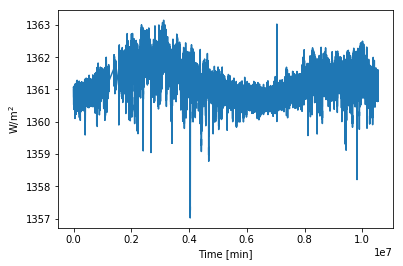

In [4]:
fluxes = hdu[0].data
times = np.arange(len(fluxes))

interp_fluxes = np.interp(times[fluxes == -99], times[fluxes != -99], fluxes[fluxes != -99])
fluxes[fluxes == -99] = interp_fluxes

plt.plot(times, fluxes)
plt.xlabel('Time [min]')
plt.ylabel('W/m$^2$')

Compute the power spectrum: 

In [5]:
from scipy.signal import periodogram
f, Pxx_den = periodogram(fluxes, fs=1/60)#, scaling='spectrum')

Compute the median of the power spectrum: 

In [6]:
from scipy.stats import binned_statistic

bs = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanmedian, bins=500)

# bs_std = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanstd, bins=500)

bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Narrow our focus to frequencies less than 5000 Hz: 

In [7]:
cutoff_freq = 5000
y = bs.statistic[1e6 * np.exp(bincenters) < cutoff_freq]
x = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters) < cutoff_freq]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

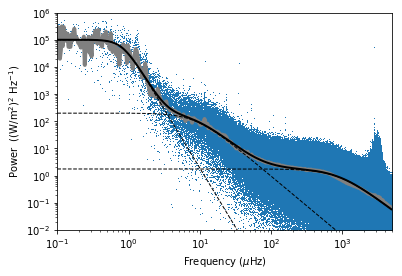

In [8]:
def individual_model(p, nu=x):
    a, b, c = p
    s = a / (1 + (b * nu)**c)
    return s

def model(p, nu=x):
    s = np.zeros_like(nu)
    for a, b, c in np.array(p).reshape((len(p)//3, 3)):
        s += a / (1 + (b * nu)**c)
    return s

def minimize(p):
    """Optimize least squares in log space"""
    return np.sum( (np.log10(y) - np.log10(model(p)))**2 )

from scipy.optimize import fmin_l_bfgs_b

initp = [1e5, 1.5, 4, 
         200, 0.08, 3, 
         2, 0, 3]
bounds = [[0.5e5, 3e5], [0.3, 2], [2, 5], 
          [100, 300], [0, 1], [2, 5], 
          [0, 5], [-1, 1], [2, 5]]

fig, ax = plt.subplots()
bestp = fmin_l_bfgs_b(minimize, initp, bounds=bounds, approx_grad=True)[0]
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
ax.loglog(x, y, color='gray', lw=4, label='Binned')
# plt.loglog(1e6 * x, model(initp))
ax.loglog(x, model(bestp), color='k', lw=2, label='Fit')
ax.loglog(x, individual_model(bestp[:3]), color='k', lw=1, ls='--')
ax.loglog(x, individual_model(bestp[3:6]), color='k', lw=1, ls='--')
ax.loglog(x, individual_model(bestp[6:9]), color='k', lw=1, ls='--')

ax.set_xlabel('Frequency ($\mu$Hz)')
ax.set_ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')

ax.set_xlim([1e-1, cutoff_freq])
ax.set_ylim([1e-2, 1e6])
plt.savefig('paper_plots/psd.png', bbox_inches='tight', dpi=250)

***

In [20]:
smoothed_spectrum = gaussian_filter1d(Pxx_den, 50)

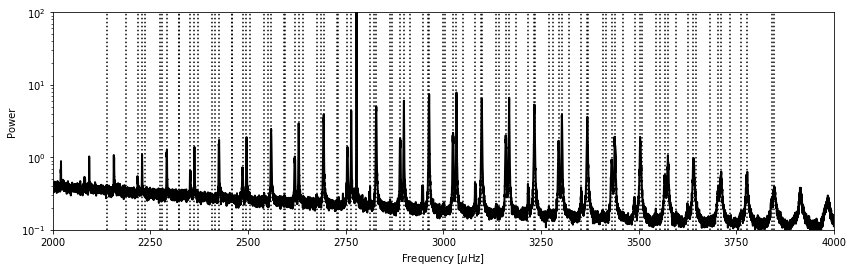

In [23]:
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(figsize=(14, 4))
#ax.semilogy(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
ax.semilogy(1e6 * f, smoothed_spectrum, lw=2, color='k')
ax.set(xlabel='Frequency [$\mu$Hz]', ylabel='Power', 
       xlim=[2000, 4000], ylim=[1e-1, 1e2])

table1 = [2228.34, 2362.96, 2496.14, 2630.03, 2764.43, 2898.95, 3033.75, 3168.67, 3303.21, 3438.95, 3574.62]

table2 = [2137.79, 2217.63, 2273.47,
2228.34, 2292.17, 2352.29, 2407.73,
2362.96, 2425.68, 2486.05, 2541.70,
2496.14, 2559.29, 2619.69, 2676.23,
2630.03, 2693.32, 2754.44, 2811.49,
2764.43, 2828.19, 2889.59, 2946.97,
2898.95, 2963.32, 3024.75, 3082.31,
3033.75, 3098.16, 3159.83, 3217.74,
3168.67, 3233.21, 3295.25, 3353.58,
3303.21, 3368.64, 3430.76, 3489.65,
3438.95, 3504.39, 3567.02, 3626.35,
3574.62, 3640.35, 3703.41, 3763.01,
3711.45, 3777.07, 3840.84, 3847.28,
2188.43, 2235.42, 2280.08, 2322.40, 
2324.31, 2371.23, 2415.59, 2458.25, 
2458.53, 2506.00, 2551.12, 2594.27, 
2593.16, 2641.25, 2687.08, 2731.08, 
2728.51, 2777.24, 2823.81, 2868.40, 
2864.28, 2913.51, 2960.62, 3005.54, 
3000.13, 3049.84, 3097.09, 3142.77, 
3135.96, 3186.26, 3234.17, 3279.76, 
3271.74, 3322.67, 3370.91, 3417.35, 
3408.14, 3459.74, 3508.80, 3554.93, 
3544.67, 3596.35, 3646.05, 3682.25, 3734.72]

for line in table2: 
    ax.axvline(line, ls=':', color='k')


***

In [55]:
np.log(2*np.pi/(3100 * 1e-6))

7.614230233900382

Optimization terminated successfully.
         Current function value: 119910.441717
         Iterations: 8
         Function evaluations: 2005


[(0.1, 100.0),
 Text(0,0.5,'Power'),
 (3000, 3200),
 Text(0.5,0,'Frequency [$\\mu$Hz]')]

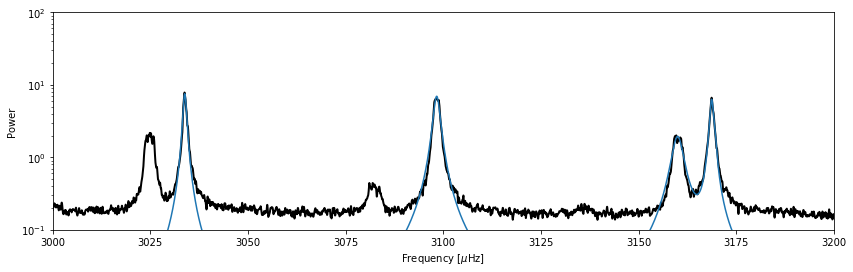

In [132]:
fig, ax = plt.subplots(figsize=(14, 4))
#ax.semilogy(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
ax.semilogy(1e6 * f, smoothed_spectrum, lw=2, color='k')

fit_bounds = ((1e6 * f < 3200) & (1e6 * f > 3000))

import celerite
from celerite import terms

from scipy.optimize import fmin_l_bfgs_b, fmin_powell


def model(p):
    kernel = None
    for p0, p1, p2 in np.array(p).reshape(len(p)//3, 3):
        if kernel is None: 
            kernel = terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
        else: 
            kernel += terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
    gp = celerite.GP(kernel)
    omega = 2*np.pi/f[fit_bounds]
    psd = gp.kernel.get_psd(omega)
    return psd 

def minimize(p):
   # return np.nansum((model(p) - smoothed_spectrum[fit_bounds])**2)
    return np.nansum((model(p) - Pxx_den[fit_bounds])**2)


initp = [-13, np.log(2*np.pi/(3100 * 1e-6)), 7.5,
         -13, np.log(2*np.pi/(3160 * 1e-6)), 7.5, 
         -13, np.log(2*np.pi/(3025 * 1e-6)), 7.5,
         -13, np.log(2*np.pi/(3028 * 1e-6)), 7.5, 
         -13, np.log(2*np.pi/(3170 * 1e-6)), 7.5]
bestp = fmin_powell(minimize, initp)
# bestp = fmin_l_bfgs_b(minimize, initp, approx_grad=True)[0]

#ax.semilogy(1e6 * f[fit_bounds], model(initp))
ax.semilogy(1e6 * f[fit_bounds], model(bestp))

ax.set(xlabel='Frequency [$\mu$Hz]', ylabel='Power', 
       xlim=[3000, 3200], ylim=[1e-1, 1e2])

In [133]:
bestp[0::3]

array([-12.67870965, -12.9606771 , -13.79249989, -16.83434539,
       -13.90341895])

Optimization terminated successfully.
         Current function value: 76.168871
         Iterations: 8
         Function evaluations: 589


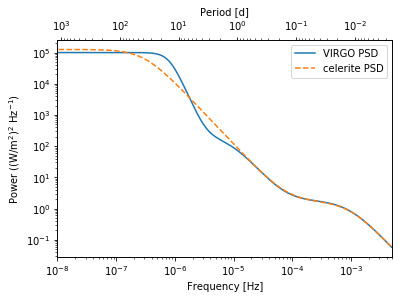

In [10]:
import celerite
from celerite import terms


kernel = (terms.SHOTerm(log_S0=10, log_omega0=-16, log_Q=1)+
         terms.SHOTerm(log_S0=10, log_omega0=-16, log_Q=1))
gp = celerite.GP(kernel)

from scipy.optimize import fmin_powell, fmin_l_bfgs_b

def minimize(p):
    gp.kernel.set_parameter_vector(p)
    return np.sum( ( np.log(model(bestp)) - np.log(gp.kernel.get_psd(2 * np.pi * x * 1e-6)) )**2 ) 

fit1 = fmin_powell(minimize, [12, -16, 1, 5, -10, 1])#, approx_grad=True)

gp.kernel.set_parameter_vector(fit1)


fig, ax = plt.subplots()
ax.loglog(x * 1e-6, model(bestp), label='VIRGO PSD')


ax.loglog(x*1e-6, gp.kernel.get_psd(2 * np.pi * x * 1e-6), ls='--', label='celerite PSD')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power ((W/m$^2$)$^2$ Hz$^{-1}$)')
ax.set_xlim([1e-8, 5e-3])

ax2 = ax.twiny()

T_f = lambda T_c: (1/T_c) / 60 / 60 / 24
# get left axis limits
xmin, xmax = ax.get_xlim()
# apply function and set transformed values to right axis limits
ax2.set_xlim((T_f(xmin),T_f(xmax)))
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
ax2.loglog([],[])
ax2.set_xlabel('Period [d]')

fig.savefig('paper_plots/psd_fit.png', bbox_inches='tight', dpi=200)
# for term in gp.kernel.terms: 
#     plt.loglog(x*1e-6, term.get_psd(x*1e-6), ls='--', color='DodgerBlue')

In [38]:
gp.compute(times)
ytest = gp.sample()

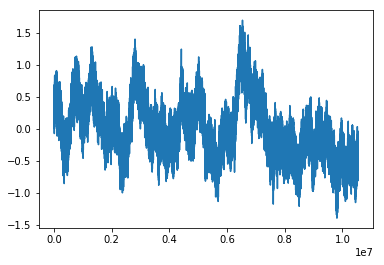

In [39]:
plt.plot(times, ytest)

In [48]:
ftest, Ptest = periodogram(ytest, fs=1/60)
bs_test = binned_statistic(np.log(ftest[1:]), Ptest[1:], statistic=np.nanmedian, bins=500)
bincenters2 = 0.5 * (bs_test.bin_edges[1:] + bs_test.bin_edges[:-1])
cutoff_freq = 5000
ytest2 = bs_test.statistic[1e6 * np.exp(bincenters2) < cutoff_freq]
xtest2 = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters2) < cutoff_freq]

xtest2 = xtest2[~np.isnan(ytest2)]
ytest2 = ytest2[~np.isnan(ytest2)]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(1e-05, 100000000.0)

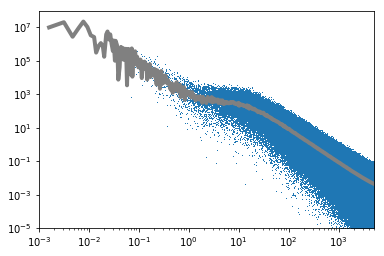

In [53]:
plt.loglog(ftest * 1e6, Ptest, ',', rasterized=True)
plt.loglog(xtest2, ytest2, color='gray', lw=4, label='Binned')
plt.xlim([1e-3, cutoff_freq])
plt.ylim([1e-5, 1e8])